We bought and installed a pair of curtains to insulate the doorway of a poorly-insulated room during cold weather.  
I was curious as to whether this had reduced our energy usage or not, so I decided to use data science to find out.  

Our house has gas central heating, so I can compare our gas usage before and after installation of the curtains.  
This should give an indication of whether the curtains reduced the heating bill.  
Our heating requirements are dependent on the outside temperature, so I need to factor this in to the calculations.
It is also worth noting that our water is heated by gas as well, so this will introduce some noise into the measurements.

The curtains were installed on 29th January. 
Having allowed a couple of months to pass for data collection post-installation, I gathered daily temperature and gas usage data for the previous 12 months.

In [1]:
change_date = "2023-01-29"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

Load in daily temperature data

In [4]:
temp_df = (
    pd.read_csv(os.path.join("Data", "temperature.csv"))
    .assign(date=lambda row: pd.to_datetime(row["date"], utc=True))
    .set_index("date")
)
temp_data_start, temp_data_end = temp_df.index.min(), temp_df.index.max()

Load in gas usage data

In [5]:
gas_df = pd.read_csv(os.path.join("Data", "gas_usage.csv"))

gas_df["interval_start"] = pd.to_datetime(gas_df["interval_start"], utc=True)

gas_df.index = gas_df["interval_start"]

# Energy usage is at half-hourly intervals
# but weather is daily. Downsample.
day_gas_df = pd.DataFrame(gas_df["consumption"].resample("D").sum())[
    temp_data_start:temp_data_end
]
day_gas_df["weekday"] = day_gas_df.index.dayofweek

We can now plot daily gas usage (black) vs minimum daily temperature (blue), to understand how the two relate. An inverse relationship is expected - the warmer it is outside, the less we need to heat the house and the lower our gas usage. The thermostat is set to 17 degrees, so we may see usage drop to zero when the external temperature is above this level.

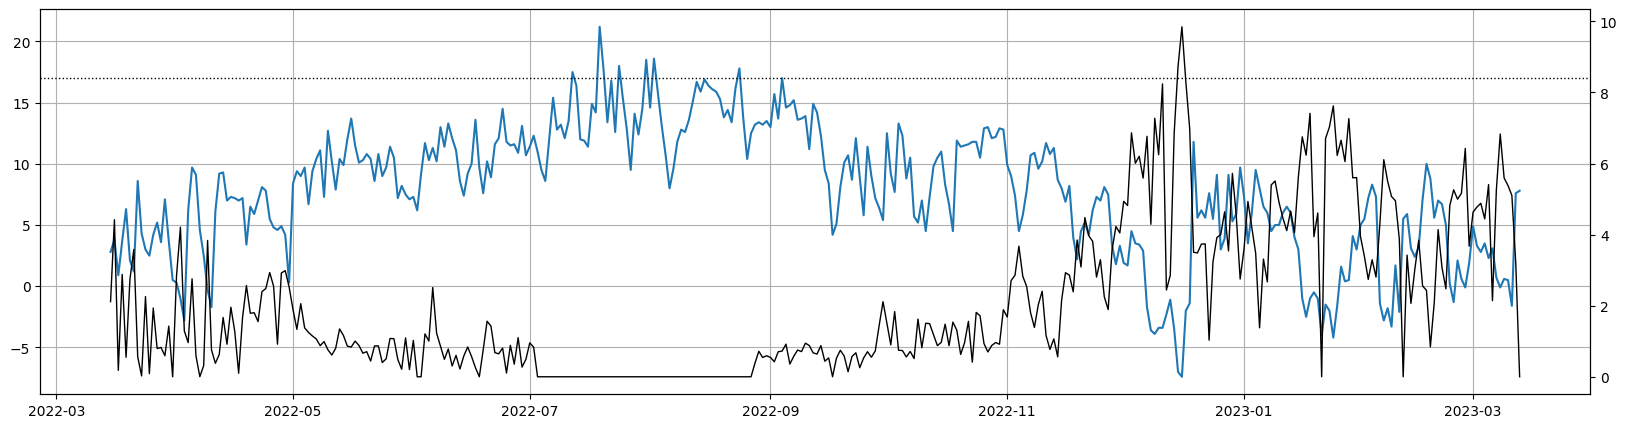

In [6]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.grid()
ax1.plot((temp_df.resample("D").min()))


# Thermostat temp setting
ax1.axhline(17, ls=":", c="k", lw=1)

ax2 = ax1.twinx()

# Invert the consumption to make it easier to read against temperature data
ax2.plot(day_gas_df["consumption"], c="k", lw=1)
# ax2.plot(day_elec_df["consumption"], c="r", lw=1)

plt.show()

As expected, a clear inverse relationship between temperature and gas usage is visible. We also see a period of zero usage over summer, where the external temperature was sufficiently high that no heating was required.

The inverse relationship can be seen more clearly using a scatter plot.  
We first combine the temperature and energy usage datasets to make visualisation easier.

In [7]:
daily_consumption_df = pd.concat(
    [day_gas_df, (temp_df.resample("D").min())], axis=1
).dropna()

We drop days where energy usage was zero, as these are outliers.

In [8]:
daily_consumption_df = daily_consumption_df[daily_consumption_df["consumption"] > 0]
plot_x, plot_y = "temperature", "consumption"

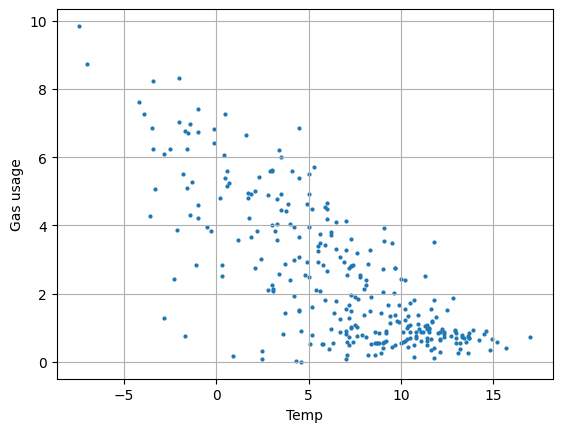

In [9]:
plt.scatter(
    daily_consumption_df[plot_x],
    daily_consumption_df[plot_y],
    s=4,
)

plt.grid()
plt.xlabel("Temp")
plt.ylabel("Gas usage")
plt.show()

The scatter plot clearly illustrates the negative relationship we're seeing.

The next question is whether there's a difference in this relationship before and after the curtain was installed.  
We can check this by looking at the regression line pre- and post-installation, comparing the both the y-intercept value (the baseline energy usage at 0 degrees outside temperature) and the coefficient (which reflects how energy use changes with temperature variation).

In [10]:
pre_X = np.array(daily_consumption_df.loc[:change_date][plot_x]).reshape(-1, 1)
pre_y = daily_consumption_df.loc[:change_date][plot_y]
post_X = np.array(daily_consumption_df.loc[change_date:][plot_x]).reshape(-1, 1)
post_y = daily_consumption_df.loc[change_date:][plot_y]

# Training a linear regression model on the data prior to the
# installation of the curtains
pre_curtain_consumption = LinearRegression().fit(pre_X, pre_y)

pre_m, pre_b = (pre_curtain_consumption.coef_, pre_curtain_consumption.intercept_)

print(f"Pre-curtain coefficient: {pre_m[0]:.3f}")
print(f"Pre-curtain intercept: {pre_b:.3f}")
print(f"Pre-curtain model R2 score: {pre_curtain_consumption.score(pre_X, pre_y):.3f}")

Pre-curtain coefficient: -0.321
Pre-curtain intercept: 4.543
Pre-curtain model R2 score: 0.546


Prior to the curtain installation, our baseline energy usage at 0 degrees outside temperature was 4.5 units, and we used 0.3 units less for each degree the temperature rose above zero.  
Although the data is quite noisy, the regression model has a reasonable R^2 score of 0.546.  

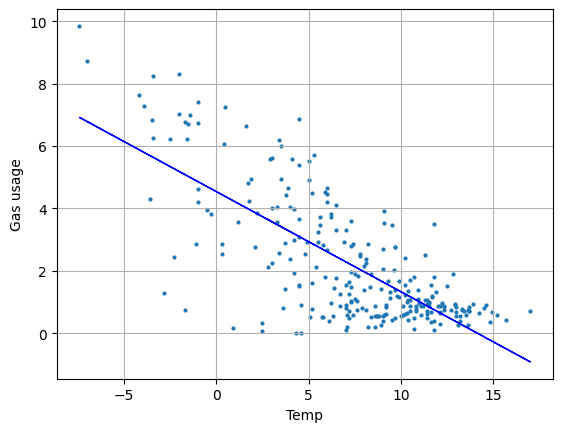

In [11]:
plt.scatter(
    daily_consumption_df.loc[:change_date][plot_x],
    daily_consumption_df.loc[:change_date][plot_y],
    s=4,
)
plt.plot(pre_X, pre_m * pre_X + pre_b, c="blue", lw=1)
plt.grid()
plt.xlabel("Temp")
plt.ylabel("Gas usage")
plt.show()

What about energy usage after curtain installation?

In [12]:
post_curtain_consumption = LinearRegression().fit(post_X, post_y)
post_m, post_b = (post_curtain_consumption.coef_, post_curtain_consumption.intercept_)

print(f"Post-curtain coefficient: {post_m[0]:.3f}")
print(f"Post-curtain intercept: {post_b:.3f}")
print(f"Post R2 score: {post_curtain_consumption.score(post_X, post_y):.3f}")

Post-curtain coefficient: -0.279
Post-curtain intercept: 5.011
Post R2 score: 0.492


Unexpectedly, baseline usage levels were higher after curtain installation, with 5.0 units used at zero degrees. Usage changed less with temperature variation, with a reduction of just 0.28 units per degree in temperature rise.  

The regression model based on the post-installation data again has a reasonable R^2 score, although it is not as good as the pre-installation model, indicating that there is more variance in the post-installation data.

Plotting the two regression lines on the same graph gives a good illustration of the difference in the models.

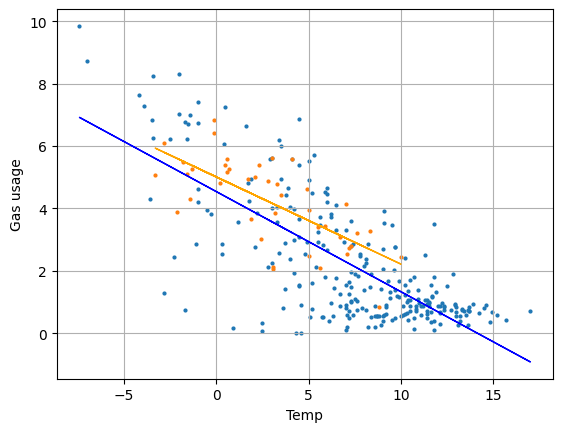

In [13]:
plt.scatter(
    daily_consumption_df.loc[:change_date][plot_x],
    daily_consumption_df.loc[:change_date][plot_y],
    s=4,
)
plt.scatter(
    daily_consumption_df.loc[change_date:][plot_x],
    daily_consumption_df.loc[change_date:][plot_y],
    s=4,
)
plt.plot(pre_X, pre_m * pre_X + pre_b, c="blue", lw=1)
plt.plot(post_X, post_m * post_X + post_b, c="orange", lw=1)
plt.xlabel("Temp")
plt.ylabel("Gas usage")
plt.grid()
plt.show()

This outcome was not expected, but could be due to a number of factors:  
- Gas usage was not solely determined by heating demands. Demand for hot water pre- and post-installation was not measured, and could be a confounding factor.
- There is much less data for energy usage post-installation, so the sample is less representative of true energy usage patterns. 
- Post-installation data covers a narrower temperature range, with no days above 10 degrees.
- Average temperature pre- and post-installation is not the same; if the relationship between the two is not strictly linear, this could explain the variation from expected behaviour.

In [14]:
print(
    "Average temperature pre-installation: "
    f"{daily_consumption_df.loc[:change_date][plot_x].mean():.2f}"
)
print(
    "Average temperature post-installation: "
    f"{daily_consumption_df.loc[change_date:][plot_x].mean():.2f}",
)

Average temperature pre-installation: 7.26
Average temperature post-installation: 3.01
